In [28]:
# LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
from common.math.bayonet_geometry import BayonetGeometryEstimator

In [29]:
# Useful functions

def mean_fraction(fractions):
    result = (fractions[0] + fractions[1]) / 2
    return result

def direct_kapitza(fraction_wetted_surface):
    result = 430 * 1.85 ** 3 * 0.832 * 0.015 * fraction_wetted_surface
    return result

def direct_kapitza_from_f_and_t(fraction_wetted_surface, delta_t):
    result = 430 * 1.85 ** 3 * 0.832 * delta_t * fraction_wetted_surface
    return result

def delta_t_from_kapitza(kapitza, fraction_wetted_surface):
    result = kapitza / (430 * 1.85 ** 3 * 0.832 * fraction_wetted_surface)
    return result

In [30]:
# CONFIGURATION BLOCK

VELOCITY = 10  # cm/s
D = 5.3  # cm
DENSITY_HELIUM_SUPERFLUID = 0.145  # g/cm3
LATENT_HEAT_VAPORIZATION = 23  # W/g

## Assumptions
* BHX with diameter of 53 mm
* 20 cells of length 5 m
* fraction of wetted perimeter at the beginning of the cell equal to 30%
* constant rate of vaporization along the tube
* constant velocity along the tube equal to 10 cm/s

## Computations
* Liquid level corresponding to  a fraction of wetted perimeter of 30% = 1.1 cm
* Cross section = 3.31 $cm^2$
* time needed for a particle to travel 5 m of the cell = 50 s
* Volume of liquid in the first cell = $3.31 cm^2 $ * $500 cm$ = $1655 cm^3$
* Mass of the helium = $1655cm^3$ * 0.145 $\frac{g}{cm^3}$ = 240 g
* Mass flow = 240 g / 50 s = 4.8g/s
* Total evaporation rate = mass flow = 4.8 g/s
* Evaporation rate for each cell = 4.8 / 20 = 0.24 g/s
* Evaporated mass in 50 s = 12 g


In [17]:
bg = BayonetGeometryEstimator(5.3, 0)

cells_length = np.ones(20) * 5.

vs = np.linspace(1655, 0, 21)
lengths = np.ones(21) * 500


liquid_levels = bg.height_from_volume(vs, lengths)
fraction_wetted_perim = bg.fraction_from_height(liquid_height=liquid_levels)

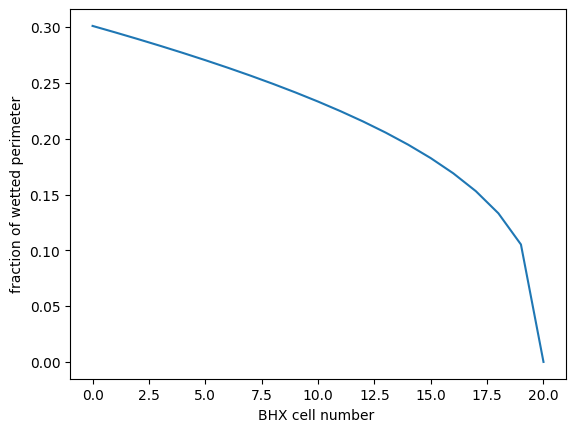

In [21]:
plt.plot(fraction_wetted_perim)
plt.xlabel('BHX cell number ')
plt.ylabel('fraction of wetted perimeter')
plt.show()

As we can deduce from the plot above even if the volume decrease linearly because we assume the same quantity of helium is vaporized in each cell ,
the fraction of wetted perimeter does not decrease linearly. This is in accordance with our expectation, due to the geometry of the circle.

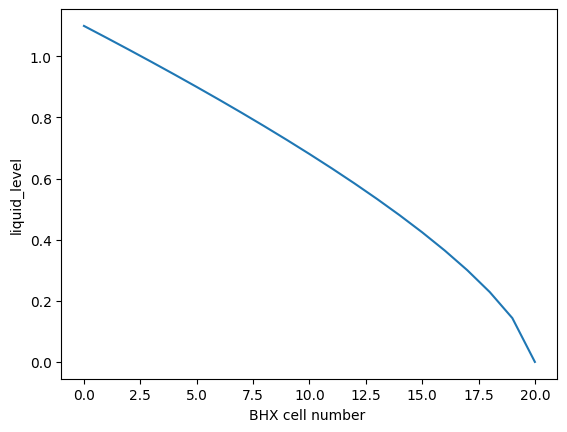

In [18]:
liquid_levels_testing = bg.height_from_fraction(fraction_wetted_perim)
plt.plot(liquid_levels_testing)
plt.xlabel('BHX cell number ')
plt.ylabel('liquid_level')
plt.show()

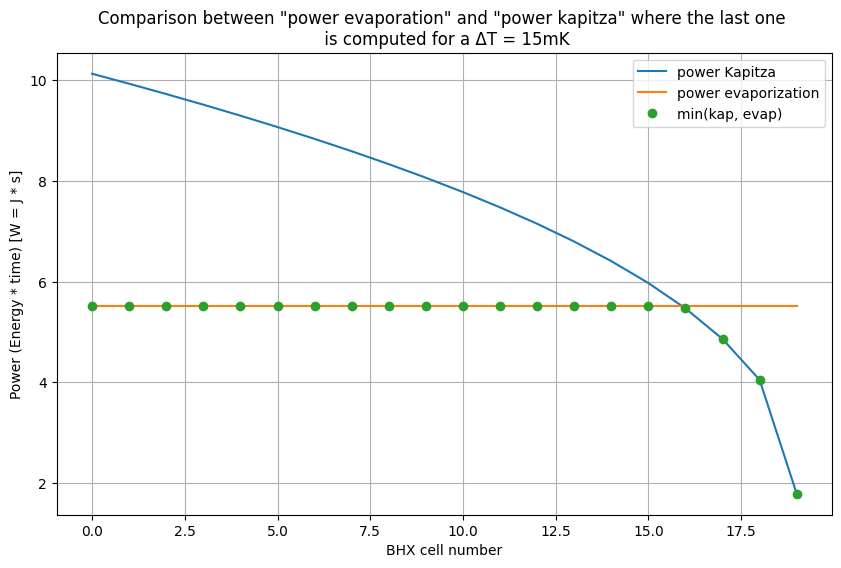

In [32]:
mean_fractions_for_kapitza = []
for i in range(0, len(fraction_wetted_perim)-1):
    mean_fractions_for_kapitza.append((fraction_wetted_perim[i] + fraction_wetted_perim[i+1]) / 2)

kapitza_power = []
for f in mean_fractions_for_kapitza:
    kapitza_power.append(direct_kapitza(f))

vs = np.linspace(1655, 0, 21)
vs_shifted = np.roll(vs, -1)

volumes_evaporated = (vs - vs_shifted)[:-1]

mass_evaporated = volumes_evaporated * DENSITY_HELIUM_SUPERFLUID / 50

energy_evaporated = mass_evaporated * LATENT_HEAT_VAPORIZATION

plt.figure(figsize=(10, 6))
plt.plot(kapitza_power, label='power Kapitza')
plt.plot(energy_evaporated, label='power evaporization')
plt.plot(np.minimum(kapitza_power, energy_evaporated), 'o' , label='min(kap, evap)')
plt.title('Comparison between "power evaporation" and "power kapitza" where the last one \n'
          ' is computed for a ΔT = 15mK')
plt.xlabel('BHX cell number')
plt.ylabel('Power (Energy * time) [W = J * s]')
plt.legend()
plt.grid()
plt.show()

The plot shows the difference between the value of the Kapitza power. so how much can be transferred for a fixed $\Delta T$ between the helium bath and the helium inside the BHX, and the "Evaporation power", which we defined as the power to evaporate a given mass of helium.
The Evaporation mass is constant and equal to 5.52 W which is the power to evaporate our 12 g of helium in 50 s.
The Kapitza power is decreasing because the fraction of wetted surface decreases along the pipe.
The green points show the minimum between the kapitza power and evaporation power.

Now we can ask ourselves what is the $\Delta T $ between the helium bath and the helium in the BHX such that the Kapitza power equalizes the evaporation power.


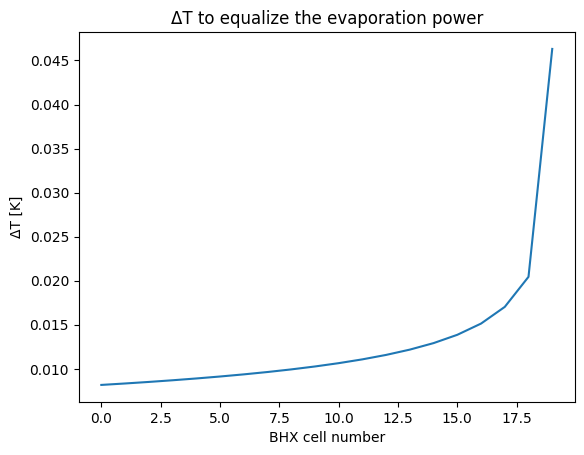

In [25]:
delta_t_to_equalize_evap = delta_t_from_kapitza(energy_evaporated, np.array(mean_fractions_for_kapitza))
plt.plot(delta_t_to_equalize_evap)
plt.title('ΔT to equalize the evaporation power')
plt.xlabel('BHX cell number')
plt.ylabel('ΔT [K]')
plt.show()

For the cells where the fraction of wetted surface is very small we need a bigger $\Delta T$ such that the energy passed through the pipe due to kapitza conductance is sufficient to vaporize the 12g of helium.

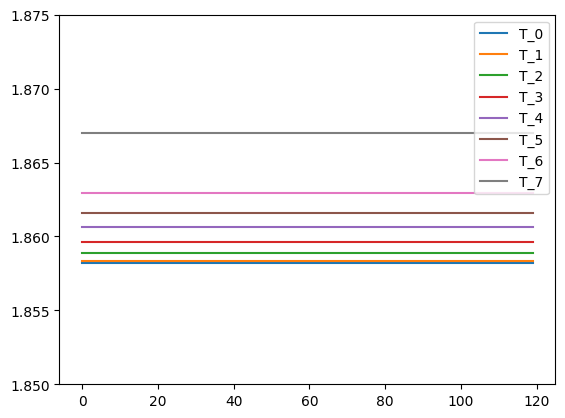

In [27]:
mask_delta_t = np.array([0, 1, 4, 7, 10, 12, 14, 17])
delta_t_masked = delta_t_to_equalize_evap[mask_delta_t]

delta_t_masked = delta_t_masked.reshape((1, -1))

temperatures = np.ones(120) * 1.85
temperatures = temperatures.reshape((-1, 1))

matrix_temp = temperatures + delta_t_masked
for i in range(len(matrix_temp[0])):
    plt.plot(matrix_temp[:, i], label=f'T_{i}')

plt.ylim(1.85, 1.875)
plt.legend()
plt.show()

Plotting just eight temperatures, we can see that the $\Delta T$ between the liquid in the BHX at 1.85 K and the helium bath is in the range of [8, 17] mK, in agreement with the experiment on the string2.